<a href="https://colab.research.google.com/github/suzzini/DS_Study/blob/main/%EB%A1%9C%EA%B7%B8%EB%B3%80%ED%99%98_%ED%9A%8C%EA%B7%80%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap
    !pip install -U scikit-learn

In [193]:
import pandas as pd
train=pd.read_csv("seoul_train.csv")
test=pd.read_csv("seoul_test.csv")

train.shape, test.shape

((91364, 13), (3911, 12))

In [194]:
#너무 큰 이상치를 제거하기 위해 가격을 기준으로 데이터를 삭제함
train=train[train['transaction_real_price']<200000]

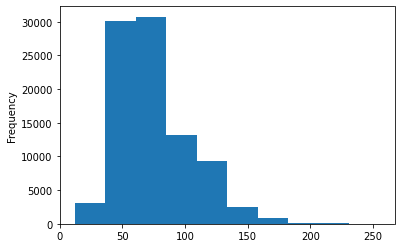

In [195]:
train['exclusive_use_area'].sort_values().plot(kind='hist')

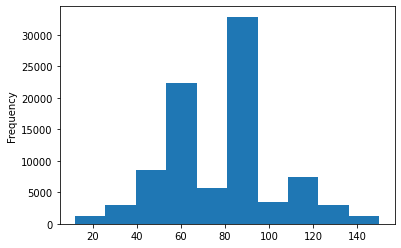

In [196]:
train=train[train['exclusive_use_area']<150]
train['exclusive_use_area'].sort_values().plot(kind='hist')

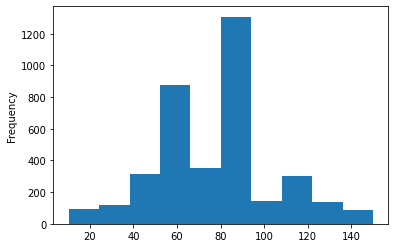

In [197]:
test=test[test['exclusive_use_area']<150]
test['exclusive_use_area'].sort_values().plot(kind='hist')

거래한 월과 지어진 지 몇년이 되었는지를 나타내는 feature을 새로 생성함

In [198]:
train['transaction_month']=train['transaction_year_month']%100
train['years_since_completion']=2017-train['year_of_completion']+1

In [199]:
test['transaction_month']=test['transaction_year_month']%100
test['years_since_completion']=2017-test['year_of_completion']+1

In [200]:
#필요없는 컬럼 삭제
train=train.drop(['transaction_id','city','jibun','addr_kr','transaction_date','transaction_year_month'],axis=1)
test=test.drop(['transaction_id','city','jibun','addr_kr','transaction_date','transaction_year_month'],axis=1)

## 공원과 관련한 데이터 셋 준비
- 같은 동에 위치한 공원의 개수 세기
- 해당 동에 위치한 공원들의 평균 면적을 계산하여 테이블 생성
- merge 옵션을 통해 기존 테이블에 공원에 관련된 컬럼 추가

In [201]:
park=pd.read_csv('park.csv')
park=park[park['city']=='서울특별시']
park

,city,gu,dong,park_name,park_type,park_area,park_exercise_facility,park_entertainment_facility,park_benefit_facility,park_cultural_facitiy,park_facility_other,park_open_year,reference_date
58,서울특별시,서초구,반포동,반 포,근린공원,26092.2,NaN,NaN,NaN,NaN,NaN,1981.0,2018-06-30
59,서울특별시,서초구,양재동,방아다리1,근린공원,2870.8,NaN,NaN,NaN,NaN,NaN,1988.0,2018-06-30
60,서울특별시,서초구,양재동,방아다리2,근린공원,2934.3,NaN,NaN,NaN,NaN,NaN,1988.0,2018-06-30
61,서울특별시,서초구,양재동,양재천,근린공원,19258.0,NaN,NaN,NaN,NaN,NaN,1988.0,2018-06-30
62,서울특별시,서초구,양재동,마 방,근린공원,6546.6,NaN,NaN,NaN,NaN,NaN,1983.0,2018-06-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354,서울특별시,구로구,천왕동,이펜시아어린이공원,어린이공원,1500.0,NaN,조합놀이 1기,NaN,NaN,NaN,2006.0,2019-02-25
1355,서울특별시,구로구,천왕동,개명소공원,소공원,5415.0,NaN,NaN,NaN,NaN,NaN,2006.0,2019-02-25
1356,서울특별시,구로구,천왕동,봉화대근린공원,근린공원,60975.0,NaN,NaN,NaN,NaN,NaN,2006.0,2019-02-25
1357,서울특별시,구로구,항동,푸른수목원,근린공원,100809.0,NaN,NaN,NaN,NaN,NaN,2005.0,2019-02-25


In [202]:
park_df=park.groupby('dong').count().iloc[:,0:1]
park_df

,city
dong,
가락동,13
가산동,3
가양동,14
갈현동,6
강일동,9
...,...
회기동,1
효창동,2
후암동,2


In [203]:
park_df['park_mean_area']=park.groupby('dong').mean().iloc[:,0:1]
park_df=park_df.reset_index()
park_df

,dong,city,park_mean_area
0,가락동,13,7914.030769
1,가산동,3,1216.866667
2,가양동,14,16307.464286
3,갈현동,6,1385.466667
4,강일동,9,23467.344444
...,...,...,...
157,회기동,1,400.000000
158,효창동,2,85901.000000
159,후암동,2,1261.000000
160,휘경동,5,1393.180000


In [204]:
#park에만 있는 dong 삭제하기 위해 dong 찾기
delete_dong_list=list(set(park_df['dong'].unique())-set(train['dong'].unique()))
delete_dong_list

['명륜3가', '청룡동', '청파동3가', '능동', '정동', '을지로5가', '원효로3가']

In [205]:
delete_park_df=park_df[(park_df['dong']=='청룡동') | (park_df['dong']=='을지로5가') | (park_df['dong']=='정동')|(park_df['dong']=='원효로3가')|(park_df['dong']=='청파동3가')|(park_df['dong']=='명륜3가')|(park_df['dong']=='능동')].index
delete_park_df

Int64Index([25, 47, 114, 116, 129, 139, 140], dtype='int64')

In [206]:
park_df_for_train=park_df.drop(delete_park_df,axis=0)
train=train.merge(park_df_for_train, on='dong',how='outer')
train.rename(columns={'city':'num_park'},inplace=True)

In [207]:
delete_dong_list_test=list(set(park_df['dong'].unique())-set(test['dong'].unique()))
delete_park_df_test=park_df[(park_df['dong']=='순화동') | (park_df['dong']=='청룡동') | (park_df['dong']=='충무로5가')|(park_df['dong']=='만리동2가')|(park_df['dong']=='능동')|(park_df['dong']=='신설동')|(park_df['dong']=='신문로1가')|(park_df['dong']=='정동')|(park_df['dong']=='합동')|(park_df['dong']=='명륜3가')|(park_df['dong']=='원효로3가')|(park_df['dong']=='영등포동2가')].index

park_df_for_test=park_df.drop(delete_park_df_test,axis=0)

In [208]:
test=test.merge(park_df_for_test, on='dong',how='outer')
test.rename(columns={'city':'num_park'},inplace=True)
test

,apartment_id,dong,apt,exclusive_use_area,year_of_completion,floor,transaction_month,years_since_completion,num_park,park_mean_area
0,10453,목동,청학,35.5500,2002,2,11,16,NaN,NaN
1,4419,목동,목동효성,84.8000,2003,4,12,15,NaN,NaN
2,4407,목동,목동신시가지6,65.1000,1986,15,12,32,NaN,NaN
3,7911,목동,애드웰(774-10),73.4100,2004,5,4,14,NaN,NaN
4,1691,목동,금호아파트(768),59.6700,1995,1,12,23,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3727,9072,당산동6가,유탑유블레스,13.3867,2012,6,7,6,NaN,NaN
3728,7593,노고산동,신촌포스빌,32.3400,2004,3,12,14,NaN,NaN
3729,7754,명륜2가,아남1,84.9000,1995,18,12,23,NaN,NaN
3730,7756,명륜2가,아남3,47.4300,1999,6,11,19,NaN,NaN


In [209]:
train=train.fillna(0)
test=test.fillna(0)

전처리 완료

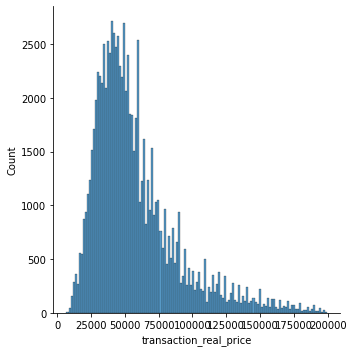

In [210]:
target = 'transaction_real_price'

sns.displot(train[target]);

왼쪽으로 편향되어 있음을 확인

## 로그변환(Log-Transform)
회귀문제에서도 한쪽으로 치우쳐 있을 때 !!!!!

- 타겟이 right-skewed 상태라면 로그변환을 사용. 비대칭 분포형태를 정규분포형태로 변환시켜줌
- **np.log1p**으로 target을 변환시켜주고 원래의 값을 얻고 싶을 때는 **np.expm1** 으로 얻을 수 있음

In [191]:
import numpy as np
#=train[train[target] < np.percentile(train[target], 99.5)][target]train[target]

In [212]:
train=train[train[target] < np.percentile(train[target], 99.5)]

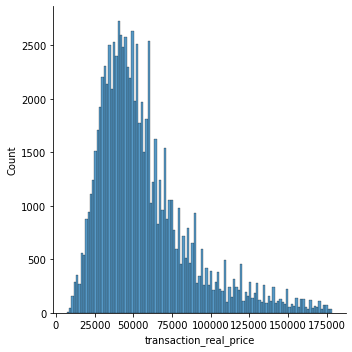

In [214]:
sns.displot(train[target]);

In [215]:
np.log1p(train[target])

0        11.112463
1        11.399768
2        11.362114
3        11.669938
4        11.320566
           ...    
88710    10.878066
88711    10.878066
88712    10.942014
88713    10.924156
88714    11.062740
Name: transaction_real_price, Length: 88254, dtype: float64

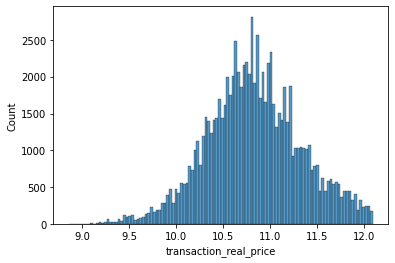

In [216]:
sns.histplot(np.log1p(train[target]));

In [217]:
train['transaction_real_price']=np.log1p(train['transaction_real_price'])

## 모델 생성하기

In [218]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.2, random_state=2)

train.shape, val.shape

((70603, 11), (17651, 11))

In [219]:
target = 'transaction_real_price'

features = train.columns.drop([target,'apt','apartment_id','year_of_completion']) #필요없는 컬럼 지우기
X_train = train[features]
y_train = train[target]
X_val= val[features]
y_val = val[target]

X_test = test[features]

In [225]:
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline

pipe_ord = make_pipeline(
    TargetEncoder(), 
 
    RandomForestRegressor(random_state=10, n_jobs=-1, oob_score=True)
)

pipe_ord.fit(X_train, y_train)
print('검증 정확도', pipe_ord.score(X_val, y_val))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


검증 정확도 0.9786503293529717


예측한 원래의 값을 얻기 위해 np.expm1이용

In [223]:
np.expm1(pipe_ord.predict(X_val))

array([ 40693.05348112,  58746.96761328,  55885.19413727, ...,
       133711.98024975, 143891.51255261,  57483.08236264])

In [234]:
pip install statsmodels.stats.outliers_influence

ERROR: Could not find a version that satisfies the requirement statsmodels.stats.outliers_influence (from versions: none)
ERROR: No matching distribution found for statsmodels.stats.outliers_influence


In [239]:
train

,apartment_id,dong,apt,exclusive_use_area,year_of_completion,floor,transaction_real_price,transaction_month,years_since_completion,num_park,park_mean_area
44921,1671,목동,금호1,114.78,1997,21,11.396403,4,21,0.0,0.000000e+00
43552,4340,신정동,명지해드는터,84.98,2003,1,11.034906,11,15,1.0,3.353000e+03
63872,5383,사당동,사당휴먼시아,59.96,2009,8,10.859018,10,9,15.0,7.694424e+04
87307,6467,암사동,선사현대아파트,58.68,2000,10,10.829748,10,18,1.0,1.022000e+03
1305,1878,신당동,남산타운,59.94,2002,9,10.915107,11,16,3.0,3.777833e+04
...,...,...,...,...,...,...,...,...,...,...,...
33895,809,중계동,건영3,84.90,1995,9,10.993748,7,23,1.0,5.334267e+06
84895,5763,길동,삼익파크맨션,131.83,1982,1,10.891187,3,36,4.0,9.949000e+02
31047,5950,상계동,상계주공14(고층),41.30,1989,11,10.118639,7,29,1.0,6.692795e+06
44596,6030,상암동,상암월드컵파크5단지,84.73,2005,3,11.156265,9,13,0.0,0.000000e+00


In [250]:
X_train=X_train.drop(['dong'],axis=1)

In [252]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF사용을 위한 라이브러리, statsmodels안에 존재한다.
# 사실 모든 통계기법이 statsmodels 모듈에 존재하여 
# 이 중에 필요한 통계기법을 찾아 import를 진행하면 된다.

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train.values, i) for i in range(train.shape[1])]
vif["features"] = train.columns
vif

,VIF Factor,features
0,13.515180,exclusive_use_area
1,3.602779,floor
2,31.067026,transaction_real_price
3,6.153162,transaction_month
4,5.449554,years_since_completion
5,1.767830,num_park
6,1.177548,park_mean_area


In [251]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF사용을 위한 라이브러리, statsmodels안에 존재한다.
# 사실 모든 통계기법이 statsmodels 모듈에 존재하여 
# 이 중에 필요한 통계기법을 찾아 import를 진행하면 된다.

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
vif

,VIF Factor,features
0,6.738648,exclusive_use_area
1,3.137174,floor
2,4.955319,transaction_month
3,3.958146,years_since_completion
4,1.666264,num_park
5,1.168678,park_mean_area
